In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load excel

In [3]:
file_path = "RB_TC_extract_2021_11_22.xlsx"
!pip install --user openpyxl
df = pd.read_excel(file_path, engine='openpyxl')
df = df.iloc[1: , :] #first line are units

     |████████████████████████████████| 242 kB 43 kB/s  eta 0:00:01


# Look at unique values

In [4]:
df.columns.values

array(['Circuit Name', 'Circuit Family', 'Period', 'Date (FGC)',
       'Time (FGC)', 'FPA Reason', 'Timestamp_PIC', 'Delta_t(FGC-PIC)',
       'Delta_t(EE_even-PIC)', 'Delta_t(EE_odd-PIC)', 'Ramp rate',
       'Plateau duration', 'I_Q_circ', 'MIITS_circ', 'I_Earth_max',
       'EE analysis', 'V feeler analysis', 'U_EE_max_ODD',
       'U_EE_max_EVEN', 'Position', 'I_Q_M', 'Nr in Q event',
       'Delta_t(iQPS-PIC)', 'nQPS crate name', 'Delta_t(nQPS-PIC)',
       'Type of Quench', 'Quench origin', 'Quench count',
       'QDS trigger origin', 'dU_iQPS/dt', 'V_symm_max', 'dV_symm/dt',
       'R_DL_max', 'I at R_DL_max', 'QH analysis', 'Short magnet ID',
       'Manufacturer', 'Inner cable type', 'Outer cable type', 'I_Q_SM18',
       'dI_Q_Acc', 'dI_Q_LHC', 'Comment', 'Analysis performed by',
       'lhcsmapi version', 'lhcsm notebook version', 'Unnamed: 46',
       'Unnamed: 47'], dtype=object)

In [6]:
df['FPA Reason'].value_counts()

Magnet quench             4042
Heater-provoked            250
QPS trip                    58
Converter trip              39
Spurious heater firing       8
Unknown                      2
Name: FPA Reason, dtype: int64

In [7]:
df['Type of Quench'].value_counts()

GHe propagation        2926
Training                885
EM disturbance          192
Heater-provoked         104
nQPS lost reference      81
Training adjacent        30
Beam-induced             21
Unknown                  18
Short-to-ground          18
QPS crate reset           8
Single Event Upset        2
EM disturbance?           1
Name: Type of Quench, dtype: int64

In [8]:
df['Nr in Q event'].value_counts()

1     918
2     850
3     827
4     722
5     403
     ... 
46      1
45      1
44      1
43      1
-       1
Name: Nr in Q event, Length: 100, dtype: int64

In [9]:
df['QDS trigger origin'].value_counts() 

iQPS         3869
nQPS          452
QPS            19
iQPs            9
iQPS/nQPS       6
?               2
No quench       2
iQPS?           1
nQPS/iQPS       1
nQPS/iQPs       1
                1
IQPS            1
Name: QDS trigger origin, dtype: int64

In [10]:
df['Position'].value_counts() 

A21L5    12
A27L5    12
A14L6    11
B21L5    11
C22R4    11
         ..
C15R3     1
A24L5     1
A19R2     1
A14R6     1
B15L1     1
Name: Position, Length: 1179, dtype: int64

In [11]:
df['Analysis performed by'].value_counts()

hagen                    1110
gwilleri                  280
jspasic                   249
zinur                     209
lfiscare                  190
syammine                  149
emm                       131
averweij                  125
bbordini                  119
slenaour                  100
dwollman                   88
bednarek                   59
Sandrine                   24
Zinur                      18
Arjan                      16
Arjan/Matthias             11
Gerard                     10
Mateusz/Jens               10
zinur/averweij              9
mmacieje                    9
Sandor + Per                8
Daniel W.                   8
Daniel C.                   7
Mateusz                     6
Jens/Mateusz                6
Mateusz and Christian       5
gerard                      5
Ivan                        4
JPh                         4
Bernhard et al              2
Gerard / Zinur(iQPS)        2
Per                         1
Name: Analysis performed by, dtype: int6

In [12]:
df['Comment'].value_counts()[:20]

                                                                           174
2008 Accident in S34                                                        99
OK                                                                          36
Special test of suspect diodes (5 first in event)                           20
Special test of suspect diodes (4 first in event)                           16
3 V feelers not working                                                     16
Training quench on 2 magnets C24R3 and B23L4                                12
QH signals not shown, analysis performed by using the RB_QHDA notebook      10
Training                                                                    10
1 feeler card disabled                                                      10
2 training quenches close together.                                          9
Training quench in 2 magnets                                                 9
-                                                   

# Histograms

In [25]:
df["Date (FGC)"] = pd.to_datetime(df["Date (FGC)"])
df["year"] = df["Date (FGC)"].dt.year.dropna()
df["month"] = df["Date (FGC)"].dt.month.dropna()

In [136]:
def plot_hist(df, column, ax, bins=None, title=None, range=None, em=True, xlim=None, ylog=False):
    df[column].hist(label="all quenches", ax=ax, bins=bins, align='left', rwidth=0.9, range=range)
    df[df['Type of Quench'] =="GHe propagation"][column].hist(label="secondary quenches (GHe)", ax=ax, bins=bins, rwidth=0.9, align='left', range=range)
    df[df['Nr in Q event'] == 1][column].hist(label="primary quenches", ax=ax, bins=bins, rwidth=0.9, align='left', range=range)
    if em:
        df[df['Type of Quench'] =="EM disturbance"][column].hist(label="secondary quenches (EM)", ax=ax, bins=bins, rwidth=0.9, align='left', range=range)
    if xlim:
        ax.set_xlim(xlim)
    if ylog:
        ax.set_yscale("log")
    ax.legend()
    ax.set_title(title)

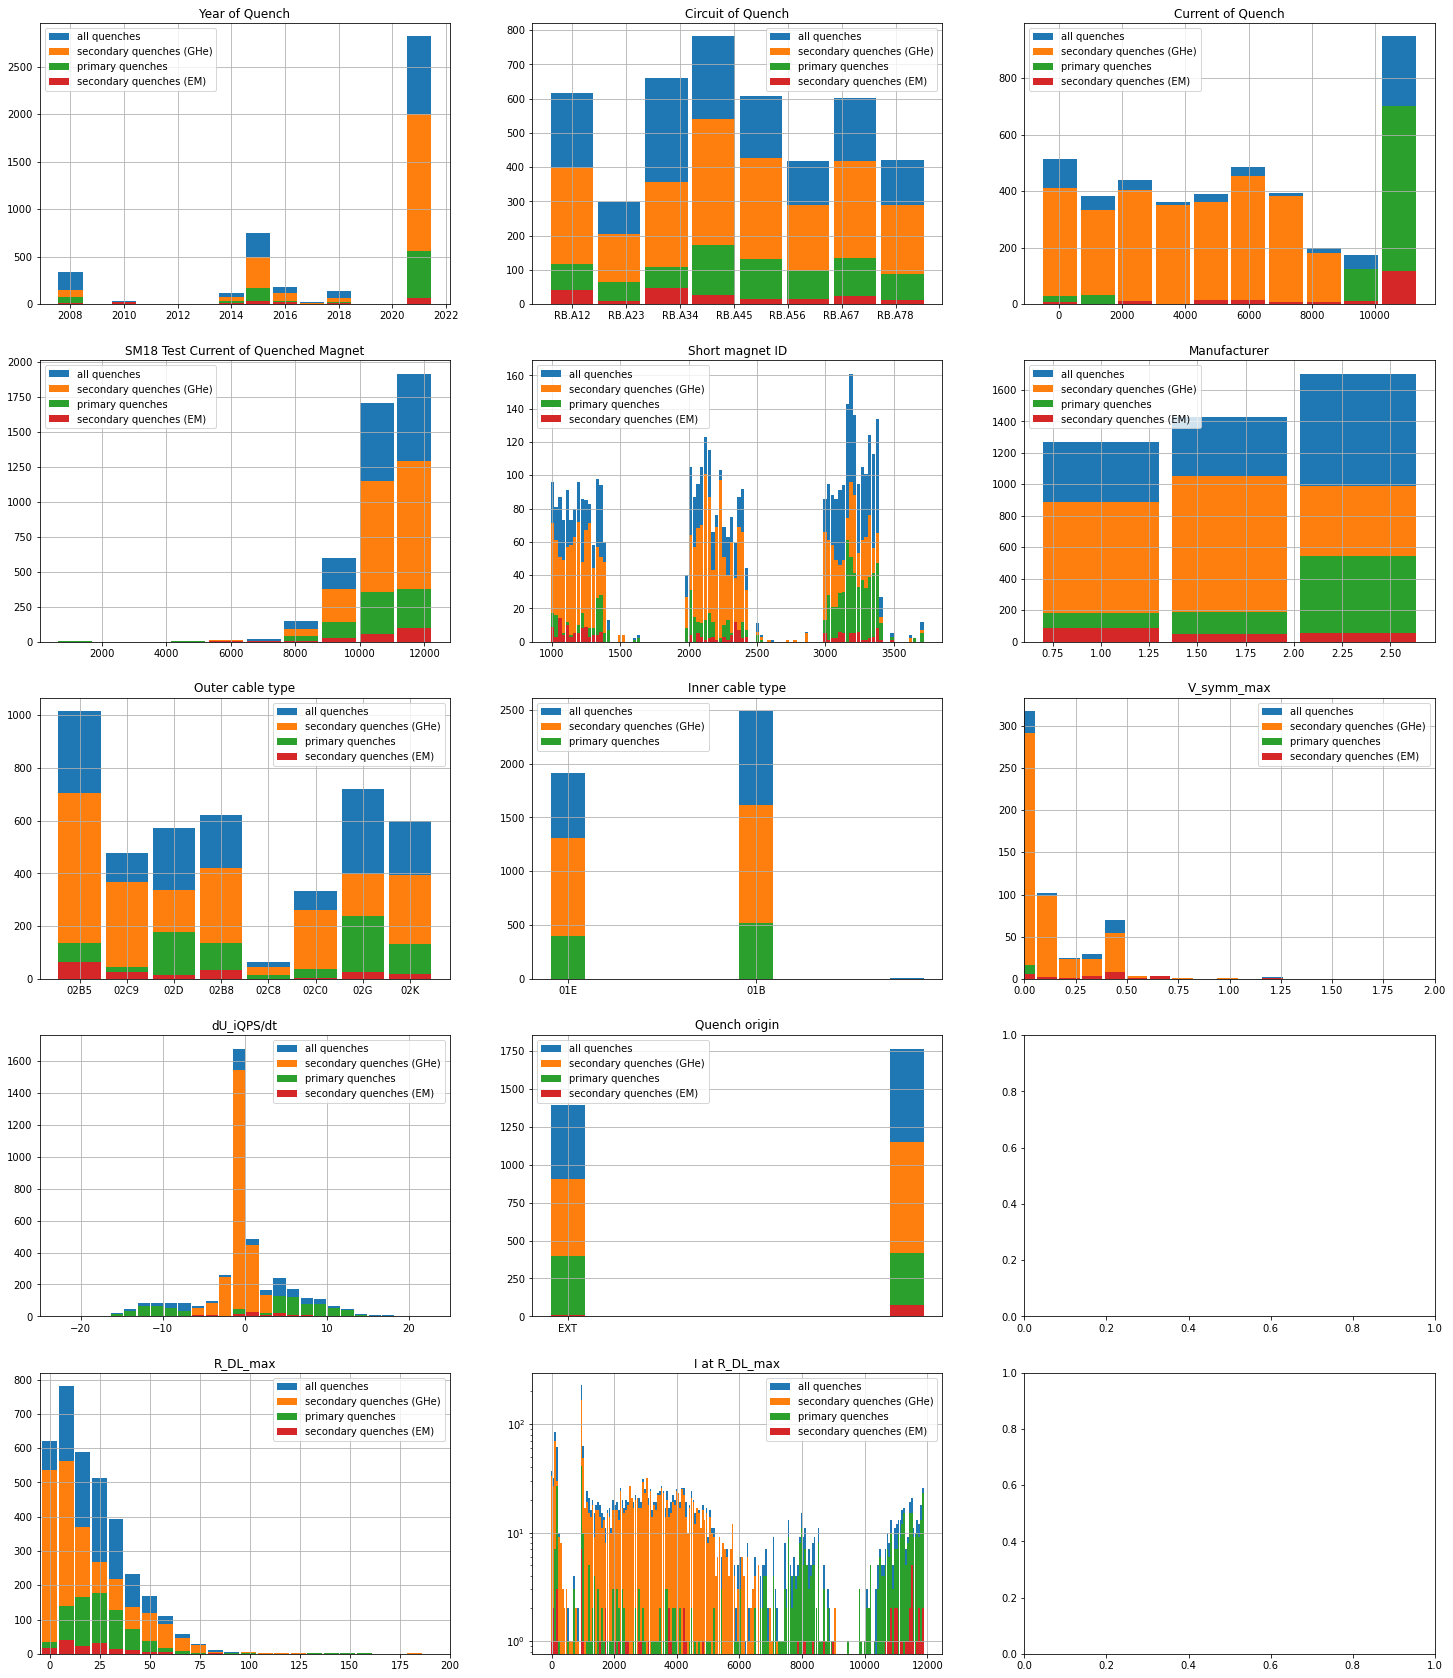

In [137]:
fig, ax = plt.subplots(5,3, figsize=(25,30))
plot_hist(df, column="year", ax=ax[0,0], bins=np.arange(2008, 2023), title="Year of Quench")
plot_hist(df, column="Circuit Name", ax=ax[0,1], bins=8, title="Circuit of Quench")
plot_hist(df, column="I_Q_M", ax=ax[0,2], title="Current of Quench", range=(df["I_Q_M"].min(), df["I_Q_M"].max()))
plot_hist(df, column="I_Q_SM18", ax=ax[1,0], title="SM18 Test Current of Quenched Magnet", range=(df["I_Q_SM18"].min(), df["I_Q_SM18"].max()))
plot_hist(df, column="Short magnet ID", ax=ax[1,1], bins=100, title="Short magnet ID", range=(df["Short magnet ID"].min(), df["Short magnet ID"].max()))
plot_hist(df, column="Manufacturer", ax=ax[1,2], bins=3, title="Manufacturer")
plot_hist(df[df["Outer cable type"].apply(lambda x: isinstance(x, str))], column="Outer cable type", ax=ax[2,0], title="Outer cable type", bins=df[df["Outer cable type"].apply(lambda x: isinstance(x, str))]["Outer cable type"].unique())
plot_hist(df, column="Inner cable type", ax=ax[2,1], title="Inner cable type", em=False)

plot_hist(df, column="V_symm_max", ax=ax[2,2], title="V_symm_max", xlim=(0,2), bins=100, range=(df["V_symm_max"].min(), df["V_symm_max"].max()))
plot_hist(df.drop(df[df["dU_iQPS/dt"].apply(lambda x: isinstance(x, str))].index), column="dU_iQPS/dt", ax=ax[3,0], title="dU_iQPS/dt", xlim=(-25,25), bins=100, range=(df.drop(df[df["dU_iQPS/dt"].apply(lambda x: isinstance(x, str))].index)["dU_iQPS/dt"].min(), df.drop(df[df["dU_iQPS/dt"].apply(lambda x: isinstance(x, str))].index)["dU_iQPS/dt"].max()))

plot_hist(df.drop(df[df["Quench origin"]=="?"].index), column="Quench origin", ax=ax[3,1], title="Quench origin")
plot_hist(df.drop(df[df["R_DL_max"].apply(lambda x: isinstance(x, str))].index), column="R_DL_max", ax=ax[4,0], title="R_DL_max", xlim=(-5,200), bins=300, range=(df.drop(df[df["R_DL_max"].apply(lambda x: isinstance(x, str))].index)["R_DL_max"].min(), df.drop(df[df["R_DL_max"].apply(lambda x: isinstance(x, str))].index)["R_DL_max"].max()))
plot_hist(df, column="I at R_DL_max", ax=ax[4,1], title="I at R_DL_max", ylog=True, bins=200, range=(df["I at R_DL_max"].min(), df["I at R_DL_max"].max()))